# Imports

In [2]:
from os import listdir,mkdir,makedirs
from os.path import isfile, join, isdir,exists
import pandas as pd
import numpy as np
from scipy import stats
import re
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from myplots import roundup, rounddown, find_decimal_fold, percentile_cut_off, rarefaction_calc, rarefaction_plot,draw_correlation_scatter
from matplotlib.ticker import FormatStrFormatter
import cPickle as pickle
from Bio.SeqUtils import GC
import seaborn as sns
import random
from scipy.stats import pearsonr,fisher_exact
from skbio.diversity.alpha import shannon, simpson, berger_parker_d

from pop_organize import get_sample_data, get_sample_with_dfs
from SufficientStatistics.SufficientStatistics import *
from MyFunctionsShani import *
import math
from myplots import roundup, rounddown, find_decimal_fold
from skbio.stats.distance import mantel
from scipy.spatial.distance import braycurtis, pdist, euclidean


from GeneralFeaturePhenotypeInteractions.Feature_phenotype_functions import * 
from TCR_microbiome_interactions.TCR_microbiome_interactions_functions import *
from TCR_microbiome_interactions.TCR_microbiome_interactions_functions2 import *
from SampleLists.SampleFileFunctions import *
from PhenotypicData.PhenotypeGenerationFunctions import *
from CardioProject.CardioFunctions import *
from PredictionPipeline.PredictionFunctions import *
from TCR_feature_generation.SubsamplingFunctions import *

import os
from Utils import cacheOnDisk
from SegalQueue.qp import qp,fakeqp
from addloglevels import sethandlers

#ML imports:
from xgboost import XGBClassifier
import lightgbm as lgb
from collections import OrderedDict
from sklearn.model_selection import GroupKFold,StratifiedKFold, KFold
import statsmodels.formula.api as sm
from sklearn.linear_model import LogisticRegression
import shap
from sklearn import metrics, preprocessing
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel,SelectKBest,chi2,mutual_info_classif,f_classif
from sklearn.naive_bayes import GaussianNB

MyPath='/net/mraid08/export/genie/Lab/Personal/ShaniBAF'

done1
stop
stop
done1
stop
done
done
done
done
stop
stop
end of function!!!

/usr/wisdom/python/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



end of function!!!


In [3]:
import time
cdate=str(time.strftime("%d%m%Y"))
cdate

'17092018'

# get phenotypes - not filtered for outliers!!!!
to enable fair comparison vs.  cardio data which is not filtered.
ages and BMI are corrected for mistakes

In [ ]:
#Age:
f1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/NewPhenotypicData/PNPage.xlsx'
PNPage=pd.read_excel(f1)

PNPage=PNPage.set_index('BD').drop('UserID',axis=1)
print len(PNPage)
PNPage.head()

In [ ]:
#Gender:
f1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/NewPhenotypicData/PNPgender.xlsx'
PNPgender=pd.read_excel(f1)

PNPgender=PNPgender.set_index('BD').drop('UserID',axis=1)
print len(PNPgender)
PNPgender.head()

In [ ]:
merged=pd.merge(PNPage,PNPgender,how='outer',left_index=True,right_index=True)
print len(merged)
print merged.head()

In [ ]:
pList=['BMI','Creatinine','Hemoglobin','WBC','CRP_wr','CRP_hs','AST','HDL','Total Cholesterol']

for p in pList:
    print p
    f1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/NewPhenotypicData/PNP_%s.xlsx' %p
    df=pd.read_excel(f1)

    df=df[['BD',p]].set_index('BD')
    print len(df)
    print df.head()
    merged=pd.merge(merged,df,how='outer',left_index=True,right_index=True)
    print len(merged)
    
    

In [ ]:
#save merged file:
f1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/NewPhenotypicData/newPhenotypeFile.xlsx'
merged.to_excel(f1)

### CALCULATE  eGFR by CKD-EPI

In [ ]:
for BD in merged.index:
    Gender=merged.loc[BD,'Gender']
    Age=merged.loc[BD,'Age']
    Creatinine=merged.loc[BD,'Creatinine']
    if Gender=='Male':
        k=0.9
        alpha=-0.411
        g=1
    elif Gender=='Female':
        k=0.7
        alpha=-0.329
        g=1.018
    else:
        k=np.nan
        alpha=np.nan
        g=np.nan
    merged.loc[BD,'eGFR_CKD-EPI_new']=141*(np.min([float(Creatinine)/k,1]))**alpha*(np.max([float(Creatinine)/k,1]))**-1.209*0.993**Age*g
merged['eGFR_CKD-EPI_new']=merged['eGFR_CKD-EPI_new'].astype('float').round(0)
merged['eGFR_CKD-EPI_new'].head()

In [ ]:
merged['eGFR_CKD-EPI_new'].describe()

In [ ]:
#save merged file:
f1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/NewPhenotypicData/PNP530_phen_new.xlsx'
merged.to_excel(f1)

In [ ]:
merged.head()

## add plate and nTemplate info from old file

In [ ]:
f1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/NewPhenotypicData/PNP530_AgeGenderBMIcreatSmoking.xlsx'
PNP530_AgeGenderBMIcreatSmoking=pd.read_excel(f1)

In [ ]:
moreInfo=PNP530_AgeGenderBMIcreatSmoking[['BD','PCRplate','nTemplates']]
merged2=pd.merge(merged,moreInfo,how='left',left_index=True,right_on='BD')
merged2=merged2.set_index('BD')
print len(merged2)
merged2.head(20)

In [ ]:
f1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/NewPhenotypicData/newPhenotypeFile.xlsx'
merged2.to_excel(f1)

## add glucose info

In [ ]:
f1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/NewPhenotypicData/PNP_NastyaPhen.xlsx'
PNP_NastyaPhen=pd.read_excel(f1)
PNP_NastyaPhen.head()

In [ ]:
glucose=PNP_NastyaPhen[['BD','HbA1C%','Median_Glucose','WakeupGlucose']]
glucose=glucose.set_index('BD')
merged2=pd.merge(merged2,glucose,how='left',left_index=True,right_index=True)
merged2.head()

## add smoking info

In [ ]:
#PNPsmoking:
f1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/NewPhenotypicData/PNP_NastyaSmokingInfo.xlsx'
PNPsmoking=pd.read_excel(f1)

PNPsmoking['Smoking']=np.where(PNPsmoking['Currently smokes']==1.0,'Yes',np.where(PNPsmoking['Ever smoked']==1.0,'Past','No'))

PNPsmoking=PNPsmoking[['BD','Smoking']].set_index('BD')
print len(PNPsmoking)
PNPsmoking.head(15)

In [ ]:
merged2=pd.merge(merged2,PNPsmoking,how='left',left_index=True,right_index=True)
print len(merged2)
print merged2.head()
print merged2.Smoking.value_counts(dropna=False)

In [ ]:
f1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/NewPhenotypicData/newPhenotypeFile.xlsx'
merged2.to_excel(f1)

# analyze phenotypic data and remove constant columns:

In [3]:
def analyzePhenFile(phenDF):
    df=pd.DataFrame()
    for n,col in enumerate(phenDF.columns):
        nans=len(phenDF[phenDF[col].isnull()])
        n9999=len(phenDF[phenDF[col]==9999])
        nCategs=len(phenDF[col].value_counts())
    #     print col,nans,n9999,nCategs
        df.loc[n,'number of Nans']=nans
        df.loc[n,'number of 9999s']=n9999
        df.loc[n,'number of categories']=nCategs
        df.loc[n,'columns']=col
    df['total nans']=df['number of Nans']+df['number of 9999s']
    df['Type']=df['number of categories'].apply(lambda x: 'constant' if x<2 else ('binary' if x==2 else ('categorial' if (x>2)&\
    (x<6) else 'Continuous')))
    
    return df
    

In [ ]:
f1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/NewPhenotypicData/newPhenotypeFile.xlsx'
newPhenotypesPNP=pd.read_excel(f1)

In [ ]:
df=pd.DataFrame()
for n,col in enumerate(newPhenotypesPNP.columns):
    nans=len(newPhenotypesPNP[newPhenotypesPNP[col].isnull()])
    n9999=len(newPhenotypesPNP[newPhenotypesPNP[col]==9999])
    nCategs=len(newPhenotypesPNP[col].value_counts())
#     print col,nans,n9999,nCategs
    df.loc[n,'number of Nans']=nans
    df.loc[n,'number of 9999s']=n9999
    df.loc[n,'number of categories']=nCategs
    df.loc[n,'columns']=col
df['total nans']=df['number of Nans']+df['number of 9999s']
df['Type']=df['number of categories'].apply(lambda x: 'constant' if x<2 else ('binary' if x==2 else ('categorial' if (x>2)&\
(x<6) else 'Continuous')))

f3='%s/TCR_real_data/NewPhenotypicData/newPhenotypesPNP_ANALYSIS.xlsx' %MyPath
df.to_excel(f3)

In [ ]:
# remove constant columns - there are no such columns now
constantdf=df[df['Type']=='constant']
constantVars=constantdf['columns'].tolist()
print constantVars
print newPhenotypesPNP.shape
newPhenotypesPNP=newPhenotypesPNP.drop(constantVars,axis=1)
print newPhenotypesPNP.shape

# Clean continuous phenotype columns:

In [ ]:
contVars=df[df['Type']=='Continuous']
contCols=contVars['columns'].tolist()
print len(contCols)
contPhenDF=newPhenotypesPNP[contCols]

In [ ]:
#look for non numeric rows:
for col in contCols:
    print col
    print contPhenDF[pd.to_numeric(contPhenDF[col], errors='coerce').isnull()][col]

# contPhenDF[contPhenDF.notnull().applymap(lambda x: isinstance(x, (int, float)))]

# clean categorial phenotypes:
for binary/multiclass columns: look for wrong values and replace with nans or correct

In [ ]:
catVars=df[(df['Type']=='binary')|(df['Type']=='categorial')]
catCols=catVars['columns'].tolist()
print len(catCols)
catPhenDF=newPhenotypesPNP[catCols]

In [ ]:
#look for strange values:
for col in catCols:
    print col
    try:
        print catPhenDF[col].value_counts(dropna=False)
    except:
        print 'couldnt'


# change column names to be similar to the cardio file:

In [ ]:
newPhenotypesPNP=newPhenotypesPNP.rename(columns={'eGFR_CKD-EPI_new':'eGFR by CKD-EPI','HbA1C%':'HbA1C','Median_Glucose':'Glucose',
                                       'Smoking':'Smoking Status','Smoking_Past':'Smoking Status_Past', 
                                        'Smoking_Yes':'Smoking Status_Yes'})

# generate dummy variables:

In [ ]:
newPhenotypesPNP=gen_dummies(newPhenotypesPNP,['Smoking Status','Gender'])


for col in newPhenotypesPNP.columns:
    newPhenotypesPNP=newPhenotypesPNP.rename(columns={col:col.replace('.0','')})
    
newPhenotypesPNP.head()

In [ ]:
f1 = '/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/NewPhenotypicData/newPhenotypesPNPAllInfo_withDummies'          
newPhenotypesPNP.to_pickle(f1)

f2 = '/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/NewPhenotypicData/newPhenotypesPNPAllInfo_withDummies.xlsx'          
newPhenotypesPNP.to_excel(f2)

# analyze again phenotype file - now with dummies:

In [4]:
f1 = '/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/NewPhenotypicData/newPhenotypesPNPAllInfo_withDummies'          
newPhenotypesPNPAllInfo_withDummies=pd.read_pickle(f1)

In [6]:
phenDF=newPhenotypesPNPAllInfo_withDummies
df=analyzePhenFile(phenDF)
f3='%s/TCR_real_data/NewPhenotypicData/newPhenotypesPNPAllInfo_withDummies_ANALYSIS.xlsx' %MyPath
df.to_excel(f3)


# compare PNP and Cardio phenotypes in order to find outliers:

## load PNP phenotypes and filter:

In [4]:
#load phenotypes:
f1 = '/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/NewPhenotypicData/newPhenotypesPNPAllInfo_withDummies'          
PNPphens=pd.read_pickle(f1).set_index('BD')

#filter for PNP530 samples and set 'BD' as index:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/PNP530','rb') as fp:
    PNP530=pickle.load(fp)
PNP530phens=PNPphens.loc[PNP530,:]
print PNP530phens.shape
print PNP530phens.head()

(530, 21)
        Age  Gender        BMI  Creatinine  Hemoglobin   WBC  CRP_wr  CRP_hs  \
BD                                                                             
BD406  65.0  Female  27.181630       1.070      13.100  6.20    0.46     NaN   
BD228  32.0    Male  28.727377       1.080      14.600  9.00    0.44     NaN   
BD714  39.0    Male  27.216277       1.015      16.025  8.05     NaN    0.04   
BD808  26.0  Female  18.423259       0.910      12.800  6.00     NaN    0.04   
BD144  36.0  Female  24.386526       0.890      13.900  7.20    0.29     NaN   

         AST   HDL     ...       eGFR by CKD-EPI  PCRplate nTemplates  HbA1C  \
BD                     ...                                                     
BD406  17.00  93.0     ...                  54.0    Plate4    11632.0   6.40   
BD228  30.00  34.8     ...                  90.0    Plate4    18964.0   5.10   
BD714  18.75  44.4     ...                  93.0    Plate8    19792.0   5.31   
BD808  16.00  64.9     ...   

## load Cardio phenotypes and filter:

In [5]:
f1 = '/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/CardioSamples/phenotypicData/Cardio126phenAllInfo_withDummies'          
Cardio126phen=pd.read_pickle(f1).set_index('BD')

print Cardio126phen.shape
Cardio126phen.head()

(126, 77)


,RegistrationCode,Age,Gender,BMI,Religion,Hypertension,Dyslipidemia,Glucose Disorder,Microvascular Complications,Past CVA/TIA,...,Chief Complaint_atypical pain,Chief Complaint_dyspnea,Chief Complaint_other,Hospitalization Duration in Past 3 Months (days)_1,Hospitalization Duration in Past 3 Months (days)_2,Hospitalization Duration in Past 3 Months (days)_7,Time elapsed from Antibiotic Tx (months)_3,Time elapsed from Antibiotic Tx (months)_4,Time elapsed from Antibiotic Tx (months)_5,Time elapsed from Antibiotic Tx (months)_6
BD,,,,,,,,,,,,,,,,,,,,,
BD950,3705508,59.0,Male,27.681661,1.0,1.0,1.0,DM2,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
BD951,3401349,64.0,Male,32.653061,1.0,0.0,0.0,PreDM,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
BD952,3697558,66.0,Female,21.501886,1.0,0.0,1.0,PreDM,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
BD953,3485604,61.0,Male,27.774271,1.0,0.0,0.0,No,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
BD955,3443343,66.0,Male,26.423570,1.0,1.0,1.0,No,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0


## find identical phenotypes:

In [ ]:
PNP530cols=PNP530phens. columns.values.tolist()
Cardio126cols=Cardio126phen.columns.values.tolist()

sameCols=list(set(PNP530cols).intersection(set(Cardio126cols)))
onlyPNP530cols=[x for x in PNP530cols if x not in sameCols]
onlyCardio126cols=[x for x in Cardio126cols if x not in sameCols]

print 'same columns:'
print sameCols

print 'onlyPNP530cols'
print onlyPNP530cols

print 'onlyCardio126cols:'
print onlyCardio126cols

In [ ]:
PNP530phens[['CRP_wr','CRP_hs']].describe()

In [ ]:
Cardio126phen['CRP'].describe()

## compare penotypes graphically

0 Age
1 BMI
2 nTemplates
3 AST
4 Hemoglobin
5 HbA1C
6 WBC
7 Total Cholesterol
8 eGFR by CKD-EPI
9 HDL
10 Creatinine
11 Glucose
0 Gender
1 Smoking Status


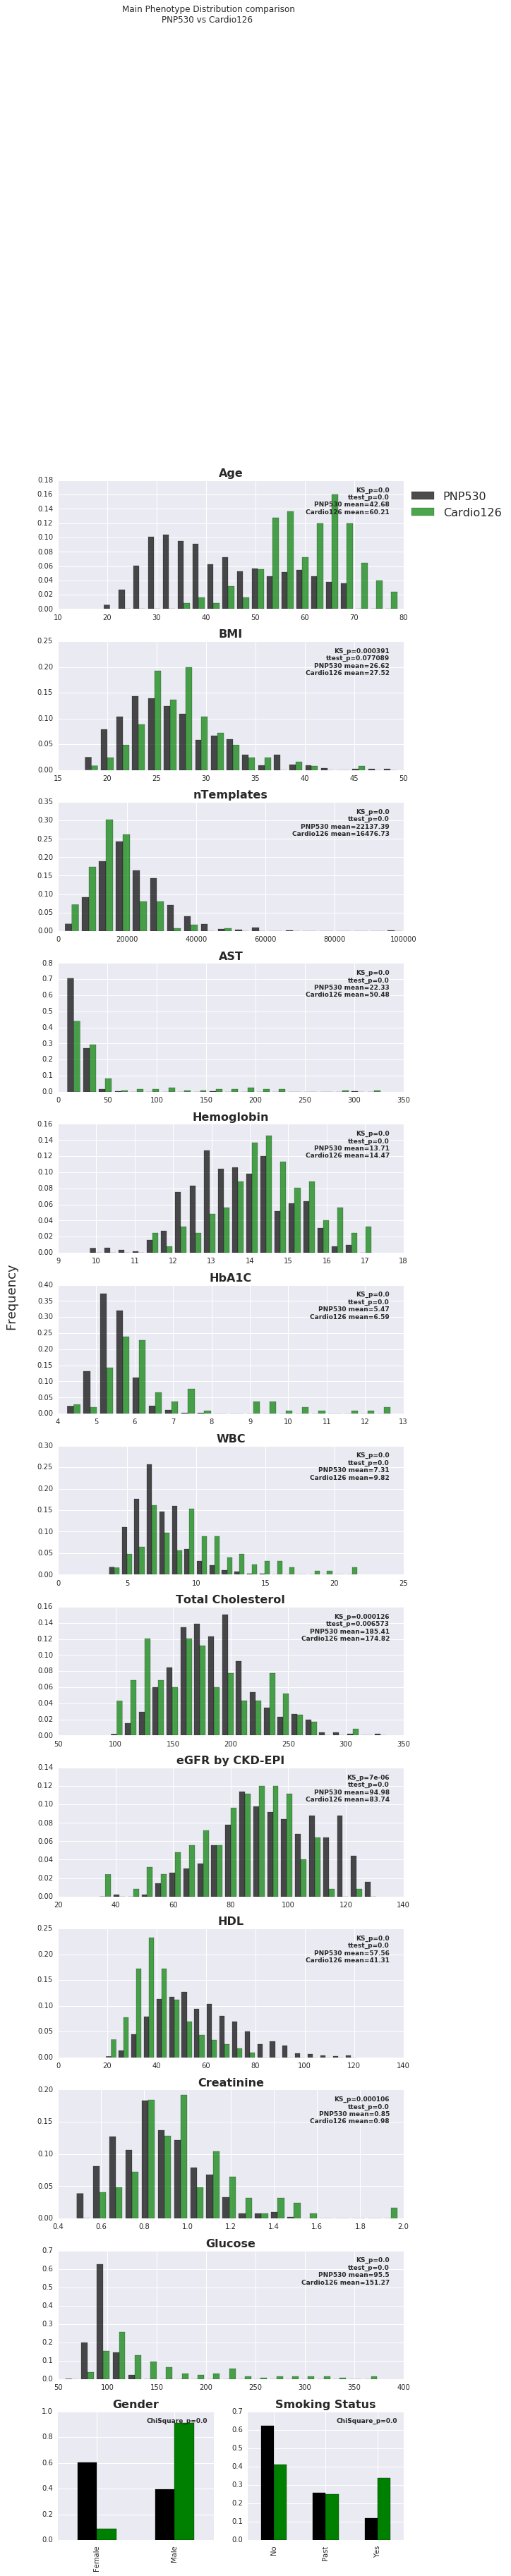

figure was saved in folder TCR_real_data/realAnalysis
done


In [6]:
numericalphenotypes=['Age', 'BMI','nTemplates', 'AST', 'Hemoglobin',  'HbA1C', 'WBC', 'Total Cholesterol',
                     'eGFR by CKD-EPI', 'HDL', 'Creatinine', 'Glucose']
categoricalphenotypes=['Gender', 'Smoking Status']

phenotypeDF1=PNP530phens

phenotypeDF2=Cardio126phen
sampleList1=None
sampleList2=None
sampleListName1=None
sampleListName2=None

datasetName1='PNP530'
datasetName2='Cardio126'
nBins=20

fig1=compare_phenotypes(numericalphenotypes,categoricalphenotypes,nBins,phenotypeDF1,sampleList1,sampleListName1,
                        datasetName1, phenotypeDF2,sampleList2,sampleListName2,datasetName2)


folderToSave='%s/TCR_real_data/NewPhenotypicData/phenotypeComparisons' %MyPath
phenotypes=''.join(numericalphenotypes+categoricalphenotypes)
if not isdir(folderToSave):
    makedirs(folderToSave)
fig1.savefig('%s/%s_%s_%s_NEW' %(folderToSave,phenotypes,datasetName1,datasetName2),dpi=300)